In [4]:
import sys
!{sys.executable} -m pip install pandas pyarrow fastparquet xgboost sklearn shap

!{sys.executable} -m pip install install --extra-index http://pypi.dcai.local --upgrade --trusted-host pypi.dcai.local dcaitrading

Looking in indexes: https://pypi.org/simple, http://pypi.dcai.local


In [5]:
import pandas as pd

df = pd.read_parquet('~/sample/sp500.parquet')

FileNotFoundError: [Errno 2] No such file or directory: '/home/dcai/sample/sp500.parquet'

In [39]:
df["direction"].unique()

array(['UP', 'DOWN', 'STAY'], dtype=object)

In [43]:
import numpy as np
import pandas as pd

def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

df["symbol"] = df["symbol"].astype("category") 

df.replace(['UP', 'DOWN', 'STAY'],
                        [0, 1, 2], inplace=True)

train, validate, test = train_validate_test_split(df, train_percent=.8, validate_percent=.1, seed=42)

print(df.shape)
print(train.shape)
print(validate.shape)

(2763113, 14)
(2210490, 14)
(276311, 14)


In [44]:


trainX = train.loc[:, train.columns != 'direction']
trainY = train.loc[:, train.columns == 'direction']

validateX = validate.loc[:, validate.columns != 'direction']
validateY = validate.loc[:, validate.columns == 'direction']

testX = test.loc[:, test.columns != 'direction']
testY = test.loc[:, test.columns == 'direction']

print(trainX.shape)
print(trainY.shape)

print(validateX.shape)
print(validateY.shape)


print(testX.shape)
print(testY.shape)

trainX["symbol"] = trainX["symbol"].astype("category")
validateX["symbol"] = validateX["symbol"].astype("category")
testX["symbol"] = testX["symbol"].astype("category")





testX.dtypes


(2210490, 13)
(2210490, 1)
(276311, 13)
(276311, 1)
(276312, 13)
(276312, 1)


<ipython-input-44-cc6490364c47>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainX["symbol"] = trainX["symbol"].astype("category")
<ipython-input-44-cc6490364c47>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validateX["symbol"] = validateX["symbol"].astype("category")
<ipython-input-44-cc6490364c47>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

symbol                         category
close_MIN_prior_5_days          float64
close_MIN_prior_20_days         float64
close_MIN_prior_260_days        float64
close_MAX_prior_5_days          float64
close_MAX_prior_20_days         float64
close_MAX_prior_260_days        float64
close_AVG_prior_5_days          float64
close_AVG_prior_20_days         float64
close_AVG_prior_260_days        float64
close_STDDEV_prior_5_days       float64
close_STDDEV_prior_20_days      float64
close_STDDEV_prior_260_days     float64
dtype: object

In [54]:
import xgboost as xgb
import matplotlib.pyplot as plt

#allow logloss and classification error plots for each iteraetion of xgb model
def plot_compare(metrics,eval_results,epochs):
    for m in metrics:
        test_score = eval_results['val'][m]
        train_score = eval_results['train'][m]
        rang = range(0, epochs)
        plt.rcParams["figure.figsize"] = [6,6]
        plt.plot(rang, test_score,"c", label="Val")
        plt.plot(rang, train_score,"orange", label="Train")
        title_name = m + " plot"
        plt.title(title_name)
        plt.xlabel('Iterations')
        plt.ylabel(m)
        lgd = plt.legend()
        plt.show()
        
def fitXgb(sk_model, training_data,epochs=300):
    print('Fitting model...')
    sk_model.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],))
    print('Fitting done!')
    train = xgb.DMatrix(training_data['X_train'], label=training_data['Y_train'])
    val = xgb.DMatrix(training_data['X_val'], label=training_data['Y_val'])
    params = sk_model.get_xgb_params()
    metrics = ['mlogloss','merror']
    params['eval_metric'] = metrics
    store = {}
    evallist = [(val, 'val'),(train,'train')]
    xgb_model = xgb.train(params, train, epochs, evallist,evals_result=store,verbose_eval=100)
    print('-- Model Report --')
    print('XGBoost Accuracy: '+str(accuracy_score(sk_model.predict(training_data['X_test']), training_data['Y_test'])))
    print('XGBoost F1-Score (Micro): '+str(f1_score(sk_model.predict(training_data['X_test']),training_data['Y_test'],average='micro')))
    plot_compare(metrics,store,epochs)
    features = ['symbol', 'close_MIN_prior_5_days', 'close_MIN_prior_20_days', 'close_MIN_prior_260_days', 'close_MAX_prior_5_days', 'close_MAX_prior_20_days', 'close_MAX_prior_260_days', 'close_AVG_prior_5_days', 'close_AVG_prior_20_days', 'close_AVG_prior_260_days', 'close_STDDEV_prior_5_days', 'close_STDDEV_prior_20_days', 'close_STDDEV_prior_260_days']
    f, ax = plt.subplots(figsize=(10,5))
    plot = sns.barplot(x=features, y=sk_model.feature_importances_)
    ax.set_title('Feature Importance')
    plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
    plt.show()

In [60]:
trainY.values.reshape(trainY.shape[0])

array([1, 1, 2, ..., 2, 0, 0])

In [100]:
from xgboost.sklearn import XGBClassifier
#initial model
store = {}
num_round = 400


features = ['symbol', 'close_MIN_prior_5_days', 'close_MIN_prior_20_days', 'close_MIN_prior_260_days', 'close_MAX_prior_5_days', 'close_MAX_prior_20_days', 'close_MAX_prior_260_days', 'close_AVG_prior_5_days', 'close_AVG_prior_20_days', 'close_AVG_prior_260_days', 'close_STDDEV_prior_5_days', 'close_STDDEV_prior_20_days', 'close_STDDEV_prior_260_days']

xgb1 = XGBClassifier(learning_rate=0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective='multi:softmax',
                    tree_method='gpu_hist',
                    num_class=3,
                    seed=27)


    
param = {'objective': 'multi:softprob', # Specify multiclass classification
         'num_class': 3, # Number of possible output classes
         'tree_method': 'gpu_hist', # Use GPU accelerated algorithm
         'enable_categorical': True,
        # 'eval_metric': 'auc',
         'eval_metric': ['mlogloss','merror'],
         'evals_result': store,
         'verbose_eval': 100
         }

dtrain = xgb.DMatrix(trainX[features], label=trainY, enable_categorical=True)
dvalidate = xgb.DMatrix(validateX[features], label=validateY, enable_categorical=True)

evallist = [(dvalidate, 'val'),(dtrain,'train')]


xgb_model = xgb.train(param, train, num_round, evallist,evals_result=store,verbose_eval=100)


/home/dcai/anaconda3/lib/python3.8/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


TypeError: ('invalid cache item: DataFrame', [        symbol  close_MIN_prior_5_days  close_MIN_prior_20_days  \
452716     CNP                1.031657                 1.031657   
2441091   SYMC                0.970980                 0.970980   
2555814    HPQ                0.975304                 0.975304   
2269741    BBY                0.929134                 0.929134   
741046     IVZ                0.840109                 0.820278   
...        ...                     ...                      ...   
1201951    WPI                1.006922                 0.936091   
237003     EOG                1.007171                 1.007171   
1212898     EW                0.990480                 0.903698   
2728641    CCI                0.990378                 0.921649   
2708621    RHT                0.993012                 0.993012   

         close_MIN_prior_260_days  close_MAX_prior_5_days  \
452716                   0.795266                1.273669   
2441091                  0.480784                1.029804   
2555814                  0.702398                1.020043   
2269741                  0.681102                1.051181   
741046                   0.526029                0.978681   
...                           ...                     ...   
1201951                  0.641661                1.020605   
237003                   1.007171                1.173539   
1212898                  0.551446                1.053094   
2728641                  0.637113                1.008935   
2708621                  0.485473                1.045973   

         close_MAX_prior_20_days  close_MAX_prior_260_days  \
452716                  1.411538                  1.479882   
2441091                 1.078431                  3.921569   
2555814                 1.078203                  1.315319   
2269741                 1.229291                  1.354331   
741046                  0.978681                  3.016609   
...                          ...                       ...   
1201951                 1.023020                  1.023020   
237003                  1.293654                  2.023664   
1212898                 1.053094                  1.053094   
2728641                 1.008935                  1.115464   
2708621                 1.094888                  1.155940   

         close_AVG_prior_5_days  close_AVG_prior_20_days  \
452716                 1.149882                 1.290355   
2441091                0.998275                 1.029137   
2555814                0.990551                 1.023318   
2269741                0.989795                 1.090504   
741046                 0.923550                 0.898128   
...                         ...                      ...   
1201951                1.015132                 1.001344   
237003                 1.098960                 1.164306   
1212898                1.012010                 0.997345   
2728641                1.001375                 0.967560   
2708621                1.009783                 1.039849   

         close_AVG_prior_260_days  close_STDDEV_prior_5_days  \
452716                   1.176568                   0.115561   
2441091                  2.210039                   0.023473   
2555814                  1.039672                   0.019200   
2269741                  0.990816                   0.043930   
741046                   1.553909                   0.055571   
...                           ...                        ...   
1201951                  0.796577                   0.005230   
237003                   1.493803                   0.075488   
1212898                  0.832163                   0.024180   
2728641                  0.885215                   0.008868   
2708621                  0.827906                   0.020932   

         close_STDDEV_prior_20_days  close_STDDEV_prior_260_days  direction  
452716                     0.112901                     0.161912          1  
2441091                    0.035492                     1.143530          1  
2555814                    0.033218                     0.119674          2  
2269741                    0.089809                     0.164377          0  
741046                     0.041779                     0.629550          2  
...                             ...                          ...        ...  
1201951                    0.024836                     0.105846          2  
237003                     0.066353                     0.199288          0  
1212898                    0.040318                     0.120630          2  
2728641                    0.028630                     0.102600          0  
2708621                    0.033323                     0.188875          0  

[2210490 rows x 14 columns], <xgboost.core.DMatrix object at 0x7fa0cba73640>, <xgboost.core.DMatrix object at 0x7fa0cb8e0be0>])

In [101]:
import xgboost as xgb
import time
num_round = 400

metrics = ['mlogloss','merror', 'auc']
# Leave most parameters as default
param = {'objective': 'multi:softprob', # Specify multiclass classification
         'num_class': 3, # Number of possible output classes
         'tree_method': 'gpu_hist', # Use GPU accelerated algorithm
         #'eval_metric': 'auc',
         'eval_metric': metrics,
         'evals_result': store,
         'verbose_eval': 100,
         'learning_rate': 0.1,
         'n_estimators':1000,
         'max_depth':5,
         'min_child_weight':1,
         'gamma':0,
         'subsample': 0.8,
         'colsample_bytree':0.8
         }

store = {}

dtrain = xgb.DMatrix(trainX, trainY, enable_categorical=True)
dvalidate = xgb.DMatrix(validateX, label=validateY, enable_categorical=True)

gpu_res = {} # Store accuracy result
tmp = time.time()
# Train model
booster = xgb.train(param, dtrain, num_round, evals=[(dvalidate, 'val'),(dtrain, 'train')], evals_result=gpu_res)
print("GPU Training Time: %s seconds" % (str(time.time() - tmp)))


[09:59:19] WARNING: ../src/learner.cc:767: 
Parameters: { "evals_result", "n_estimators", "verbose_eval" } are not used.

[0]	val-mlogloss:1.07919	val-merror:0.45414	val-auc:0.63433	train-mlogloss:1.07893	train-merror:0.45039	train-auc:0.63777
[1]	val-mlogloss:1.06289	val-merror:0.45317	val-auc:0.63723	train-mlogloss:1.06235	train-merror:0.44933	train-auc:0.64119
[2]	val-mlogloss:1.04898	val-merror:0.45284	val-auc:0.63837	train-mlogloss:1.04821	train-merror:0.44921	train-auc:0.64228
[3]	val-mlogloss:1.03717	val-merror:0.45260	val-auc:0.63960	train-mlogloss:1.03620	train-merror:0.44900	train-auc:0.64331
[4]	val-mlogloss:1.02710	val-merror:0.45225	val-auc:0.64075	train-mlogloss:1.02595	train-merror:0.44913	train-auc:0.64436
[5]	val-mlogloss:1.01845	val-merror:0.45227	val-auc:0.64153	train-mlogloss:1.01713	train-merror:0.44891	train-auc:0.64502
[6]	val-mlogloss:1.01105	val-merror:0.45232	val-auc:0.64172	train-mlogloss:1.00955	train-merror:0.44882	train-auc:0.64524
[7]	val-mlogloss:1.00471

[66]	val-mlogloss:0.96388	val-merror:0.45005	val-auc:0.64901	train-mlogloss:0.95786	train-merror:0.44483	train-auc:0.65507
[67]	val-mlogloss:0.96387	val-merror:0.45000	val-auc:0.64902	train-mlogloss:0.95781	train-merror:0.44479	train-auc:0.65512
[68]	val-mlogloss:0.96385	val-merror:0.45005	val-auc:0.64905	train-mlogloss:0.95774	train-merror:0.44473	train-auc:0.65520
[69]	val-mlogloss:0.96384	val-merror:0.45018	val-auc:0.64906	train-mlogloss:0.95768	train-merror:0.44468	train-auc:0.65526
[70]	val-mlogloss:0.96383	val-merror:0.45012	val-auc:0.64907	train-mlogloss:0.95764	train-merror:0.44467	train-auc:0.65530
[71]	val-mlogloss:0.96381	val-merror:0.45007	val-auc:0.64909	train-mlogloss:0.95758	train-merror:0.44462	train-auc:0.65536
[72]	val-mlogloss:0.96379	val-merror:0.45006	val-auc:0.64912	train-mlogloss:0.95754	train-merror:0.44459	train-auc:0.65540
[73]	val-mlogloss:0.96376	val-merror:0.45011	val-auc:0.64917	train-mlogloss:0.95748	train-merror:0.44457	train-auc:0.65547
[74]	val-mloglos

[133]	val-mlogloss:0.96311	val-merror:0.44970	val-auc:0.65019	train-mlogloss:0.95530	train-merror:0.44305	train-auc:0.65808
[134]	val-mlogloss:0.96310	val-merror:0.44961	val-auc:0.65021	train-mlogloss:0.95528	train-merror:0.44304	train-auc:0.65811
[135]	val-mlogloss:0.96308	val-merror:0.44963	val-auc:0.65023	train-mlogloss:0.95525	train-merror:0.44299	train-auc:0.65814
[136]	val-mlogloss:0.96308	val-merror:0.44958	val-auc:0.65023	train-mlogloss:0.95523	train-merror:0.44298	train-auc:0.65817
[137]	val-mlogloss:0.96308	val-merror:0.44953	val-auc:0.65024	train-mlogloss:0.95520	train-merror:0.44293	train-auc:0.65821
[138]	val-mlogloss:0.96308	val-merror:0.44954	val-auc:0.65023	train-mlogloss:0.95517	train-merror:0.44292	train-auc:0.65824
[139]	val-mlogloss:0.96307	val-merror:0.44954	val-auc:0.65024	train-mlogloss:0.95514	train-merror:0.44290	train-auc:0.65828
[140]	val-mlogloss:0.96307	val-merror:0.44963	val-auc:0.65025	train-mlogloss:0.95511	train-merror:0.44286	train-auc:0.65831
[141]	va

[200]	val-mlogloss:0.96267	val-merror:0.44953	val-auc:0.65089	train-mlogloss:0.95364	train-merror:0.44181	train-auc:0.66017
[201]	val-mlogloss:0.96267	val-merror:0.44948	val-auc:0.65089	train-mlogloss:0.95362	train-merror:0.44178	train-auc:0.66019
[202]	val-mlogloss:0.96266	val-merror:0.44956	val-auc:0.65090	train-mlogloss:0.95360	train-merror:0.44179	train-auc:0.66022
[203]	val-mlogloss:0.96266	val-merror:0.44943	val-auc:0.65090	train-mlogloss:0.95358	train-merror:0.44176	train-auc:0.66024
[204]	val-mlogloss:0.96267	val-merror:0.44952	val-auc:0.65090	train-mlogloss:0.95356	train-merror:0.44175	train-auc:0.66027
[205]	val-mlogloss:0.96266	val-merror:0.44952	val-auc:0.65091	train-mlogloss:0.95354	train-merror:0.44174	train-auc:0.66029
[206]	val-mlogloss:0.96265	val-merror:0.44946	val-auc:0.65092	train-mlogloss:0.95352	train-merror:0.44171	train-auc:0.66032
[207]	val-mlogloss:0.96265	val-merror:0.44951	val-auc:0.65092	train-mlogloss:0.95350	train-merror:0.44170	train-auc:0.66034
[208]	va

[267]	val-mlogloss:0.96250	val-merror:0.44955	val-auc:0.65120	train-mlogloss:0.95227	train-merror:0.44083	train-auc:0.66182
[268]	val-mlogloss:0.96250	val-merror:0.44952	val-auc:0.65120	train-mlogloss:0.95225	train-merror:0.44079	train-auc:0.66184
[269]	val-mlogloss:0.96250	val-merror:0.44953	val-auc:0.65120	train-mlogloss:0.95224	train-merror:0.44078	train-auc:0.66187
[270]	val-mlogloss:0.96250	val-merror:0.44957	val-auc:0.65121	train-mlogloss:0.95221	train-merror:0.44075	train-auc:0.66189
[271]	val-mlogloss:0.96250	val-merror:0.44956	val-auc:0.65121	train-mlogloss:0.95219	train-merror:0.44072	train-auc:0.66192
[272]	val-mlogloss:0.96249	val-merror:0.44955	val-auc:0.65122	train-mlogloss:0.95217	train-merror:0.44071	train-auc:0.66194
[273]	val-mlogloss:0.96249	val-merror:0.44953	val-auc:0.65122	train-mlogloss:0.95215	train-merror:0.44069	train-auc:0.66196
[274]	val-mlogloss:0.96248	val-merror:0.44957	val-auc:0.65123	train-mlogloss:0.95214	train-merror:0.44069	train-auc:0.66198
[275]	va

[334]	val-mlogloss:0.96234	val-merror:0.44973	val-auc:0.65146	train-mlogloss:0.95104	train-merror:0.43992	train-auc:0.66331
[335]	val-mlogloss:0.96234	val-merror:0.44975	val-auc:0.65146	train-mlogloss:0.95102	train-merror:0.43991	train-auc:0.66333
[336]	val-mlogloss:0.96234	val-merror:0.44974	val-auc:0.65147	train-mlogloss:0.95100	train-merror:0.43987	train-auc:0.66335
[337]	val-mlogloss:0.96233	val-merror:0.44971	val-auc:0.65147	train-mlogloss:0.95098	train-merror:0.43985	train-auc:0.66338
[338]	val-mlogloss:0.96233	val-merror:0.44967	val-auc:0.65148	train-mlogloss:0.95097	train-merror:0.43983	train-auc:0.66340
[339]	val-mlogloss:0.96233	val-merror:0.44976	val-auc:0.65148	train-mlogloss:0.95095	train-merror:0.43984	train-auc:0.66342
[340]	val-mlogloss:0.96233	val-merror:0.44971	val-auc:0.65148	train-mlogloss:0.95093	train-merror:0.43984	train-auc:0.66343
[341]	val-mlogloss:0.96232	val-merror:0.44970	val-auc:0.65149	train-mlogloss:0.95091	train-merror:0.43983	train-auc:0.66346
[342]	va

In [105]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
import seaborn as sns

dtest = xgb.DMatrix(testX, testY, enable_categorical=True)
pred = booster.predict(dtest)
pred_vect = np.argmax(pred, axis=1).reshape(-1,1)

SHAP = booster.predict(dtest, pred_contribs=True)

-- Model Report --
XGBoost Accuracy: 0.551083557717363
XGBoost F1-Score (Micro): 0.551083557717363


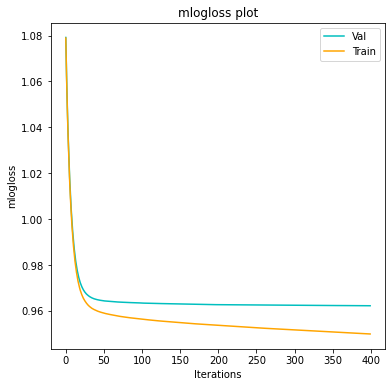

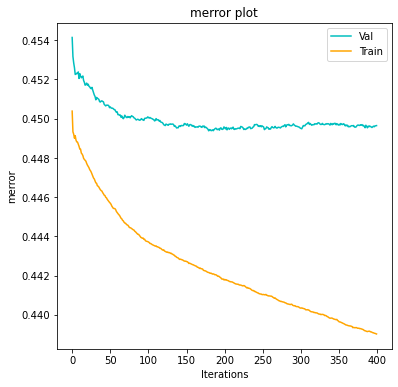

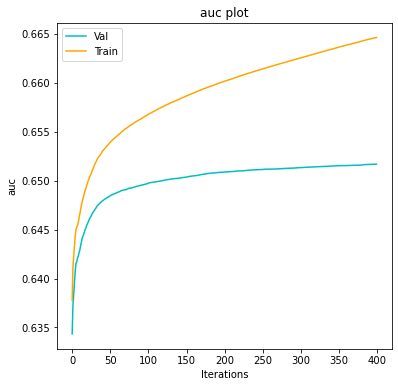

AttributeError: 'Booster' object has no attribute 'feature_importances_'

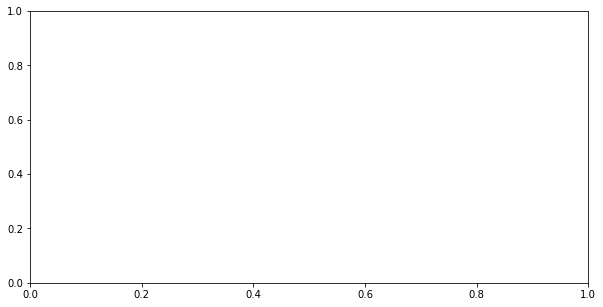

In [104]:

features = ['symbol', 'close_MIN_prior_5_days', 'close_MIN_prior_20_days', 'close_MIN_prior_260_days', 'close_MAX_prior_5_days', 'close_MAX_prior_20_days', 'close_MAX_prior_260_days', 'close_AVG_prior_5_days', 'close_AVG_prior_20_days', 'close_AVG_prior_260_days', 'close_STDDEV_prior_5_days', 'close_STDDEV_prior_20_days', 'close_STDDEV_prior_260_days']



print('-- Model Report --')
print('XGBoost Accuracy: '+str(accuracy_score(pred_vect, testY)))
print('XGBoost F1-Score (Micro): '+str(f1_score(pred_vect,testY,average='micro')))
plot_compare(metrics,gpu_res,num_round)
features = ['symbol', 'close_MIN_prior_5_days', 'close_MIN_prior_20_days', 'close_MIN_prior_260_days', 'close_MAX_prior_5_days', 'close_MAX_prior_20_days', 'close_MAX_prior_260_days', 'close_AVG_prior_5_days', 'close_AVG_prior_20_days', 'close_AVG_prior_260_days', 'close_STDDEV_prior_5_days', 'close_STDDEV_prior_20_days', 'close_STDDEV_prior_260_days']
f, ax = plt.subplots(figsize=(10,5))
plot = sns.barplot(x=features, y=booster.feature_importances_)
ax.set_title('Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
plt.show()

In [71]:
pred = booster.predict(dtest)

In [89]:


# Find the index of the highest value in each row
index_of_max = np.argmax(pred, axis=1).reshape(-1,1)

# Print the resulting 1D numpy array
print(index_of_max)
print(testY.values)
testY.shape

[[2]
 [2]
 [2]
 ...
 [1]
 [2]
 [2]]
[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [2]]


(276312, 1)